In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as cv2
import numpy as np
import glob,os
import cv2
get_ipython().magic('matplotlib inline')
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from moviepy.editor import VideoFileClip
from sklearn.model_selection import train_test_split
import time
from scipy.ndimage.measurements import label
from scipy.ndimage.morphology import generate_binary_structure


## Defining some important function

In [11]:
#Some important functions to be used in the model

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if len(img)!=64:
        img = cv2.resize(img, (64,64))
    
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
#extract all the features
def extract_features(imgs, color_space='BGR', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):

    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        # apply color conversion if other than 'BGR'
        
        if color_space != 'BGR':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
    
    

    
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list




# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []

    #2) Apply color conversion if other than 'RGB'
    if color_space != 'BGR':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='BGR', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

    
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

print("everything works well")




everything works well


### Making my model

In [12]:
images = glob.glob('vehicles/*/*.png')
cars = []
for fname in images:
    cars.append(fname)
    
images = glob.glob('non-vehicles/*/*.png')
notcars = []
for fname in images:
    notcars.append(fname)
    
print("No. of car images = ")
print(len(cars))
print("example: ")
print(cars[50])
print("No. of not car images = ")
print(len(notcars))
print("example: ")
print(notcars[933])

No. of car images = 
8792
example: 
vehicles\GTI_Far\image0072.png
No. of not car images = 
8968
example: 
non-vehicles\Extras\extra2098.png


In [13]:
color_space = 'YCrCb'
#spatial binning dimensions
spatial_size = (16, 16)
hist_bins = 32
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"
spatial_feat=True
hist_feat=True
hog_feat=True


t1 = time.time()

car_features = extract_features(cars, color_space = color_space, spatial_size = spatial_size, hist_bins = hist_bins, 
                                orient = orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, 
                                hog_channel = hog_channel, spatial_feat = spatial_feat, hist_feat = hist_feat,
                               hog_feat = hog_feat)

notcar_features = extract_features(notcars, color_space = color_space, spatial_size = spatial_size, hist_bins = hist_bins, 
                                orient = orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, 
                                hog_channel = hog_channel, spatial_feat = spatial_feat, hist_feat = hist_feat,
                               hog_feat = hog_feat)

t2 = time.time()

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print(round(t2-t1, 2), "seconds to extract features")

t2 = time.time()
# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Train the SVC
svc.fit(X_train, y_train)

t3 = time.time()

print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
print(round(t3-t2, 2), "seconds to train SVC()")

from sklearn.externals import joblib
joblib.dump(svc, 'SVM_model.pkl') 
print("Model Saved...")

#clf = joblib.load('filename.pkl')

209.67 seconds to extract features
Test Accuracy of SVC =  0.991554054054
22.78 seconds to train SVC()
Model Saved...


In [14]:
# test_img = ".//test_images//test6.jpg"
# test_img = cv2.imread(test_img)
# test_features, test_hog = get_hog_features(test_img[0:200,400:600,2], orient = 9, pix_per_cell=8, cell_per_block=2, 
#                         vis=True, feature_vec=True)
# print(len(test_features))
# plt.imshow(test_hog, cmap='gray')

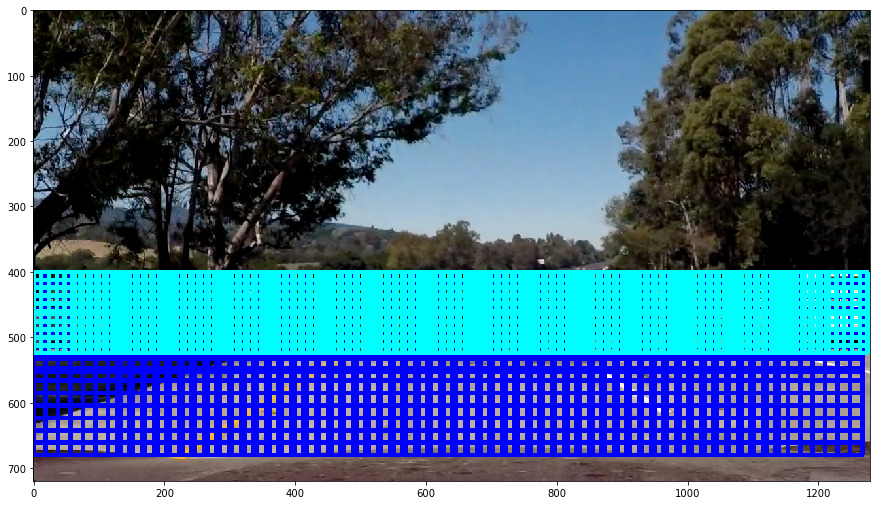

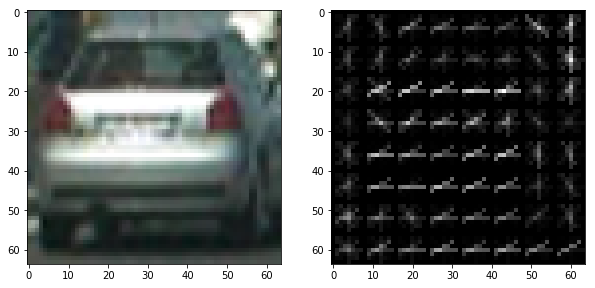

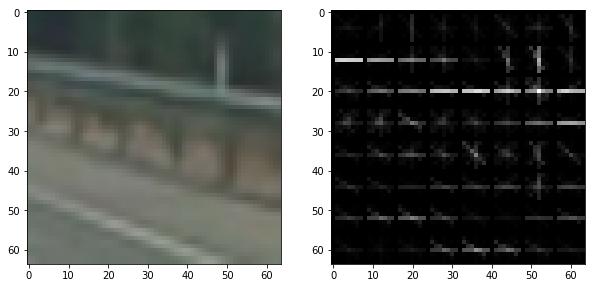

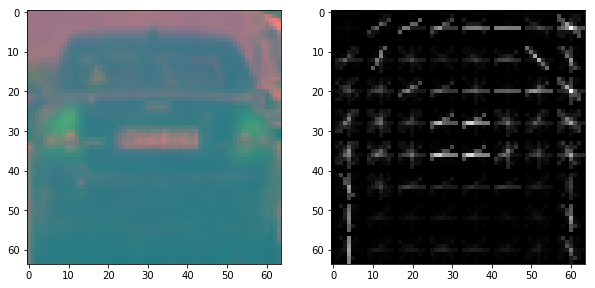

In [42]:
%matplotlib inline
import matplotlib.image as mpimg
test_img = ".//test_images//test5.jpg"
test_img = cv2.imread(test_img)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
# pt = (800, 400)
# size = 128
# cv2.rectangle(test_img, (pt[0], pt[1]), (pt[0]+size, pt[1] + size), (0,0,255), 5)
windows1 = slide_window(test_img, y_start_stop = [400, 680], xy_window=(128, 128), xy_overlap = (0.85, 0.85))
windows2 = slide_window(test_img, y_start_stop = [400, 530], xy_window=(64, 64), xy_overlap = (0.80, 0.80))
test_img = draw_boxes(test_img, windows1, color=(0,0,255), thick = 6)
test_img = draw_boxes(test_img, windows2, color=(0,255,255), thick = 6)
plt.figure(1, figsize=(15,15))
plt.imshow(test_img)
plt.imsave(".//readme_images//sliding_windows.jpg", test_img)




car_img = ".//vehicles//GTI_Far//image0225.png"
car_img = mpimg.imread(car_img)
car_img = car_img*255
car_img = car_img.astype(np.uint8)
hog_features, car_hog_img = get_hog_features(car_img[:,:,0], vis=True, orient=8, pix_per_cell=8, cell_per_block=2)
plt.figure(2, figsize=(10, 20))
plt.subplot(121)
plt.imshow(car_img)
plt.subplot(122)
plt.imshow(car_hog_img, cmap='gray')
plt.savefig(".//readme_images//carhog.jpg", bbox_inches='tight')


notcar_img = ".//non-vehicles//GTI//image150.png"
notcar_img = mpimg.imread(notcar_img)
notcar_img = notcar_img*255
notcar_img = notcar_img.astype(np.uint8)
hog_features, notcar_hog_img = get_hog_features(notcar_img[:,:,0], vis=True, orient=8, pix_per_cell=8, cell_per_block=2)
plt.figure(3, figsize=(10, 20))
plt.subplot(121)
plt.imshow(notcar_img)
plt.subplot(122)
plt.imshow(notcar_hog_img, cmap='gray')
plt.savefig(".//readme_images//notcarhog.jpg", bbox_inches='tight')


car_img = ".//vehicles//GTI_MiddleClose//image0006.png"
car_img = mpimg.imread(car_img)
car_img = car_img*255
car_img = car_img.astype(np.uint8)
car_img = cv2.cvtColor(car_img, cv2.COLOR_RGB2YCR_CB)
hog_features, car_hog_img = get_hog_features(car_img[:,:,0], vis=True, orient=8, pix_per_cell=8, cell_per_block=2)
plt.figure(4, figsize=(10, 20))
plt.subplot(121)
plt.imshow(car_img)
plt.subplot(122)
plt.imshow(car_hog_img, cmap='gray')
plt.savefig(".//readme_images//Ycarhog.jpg", bbox_inches='tight')






### Testing the parameters

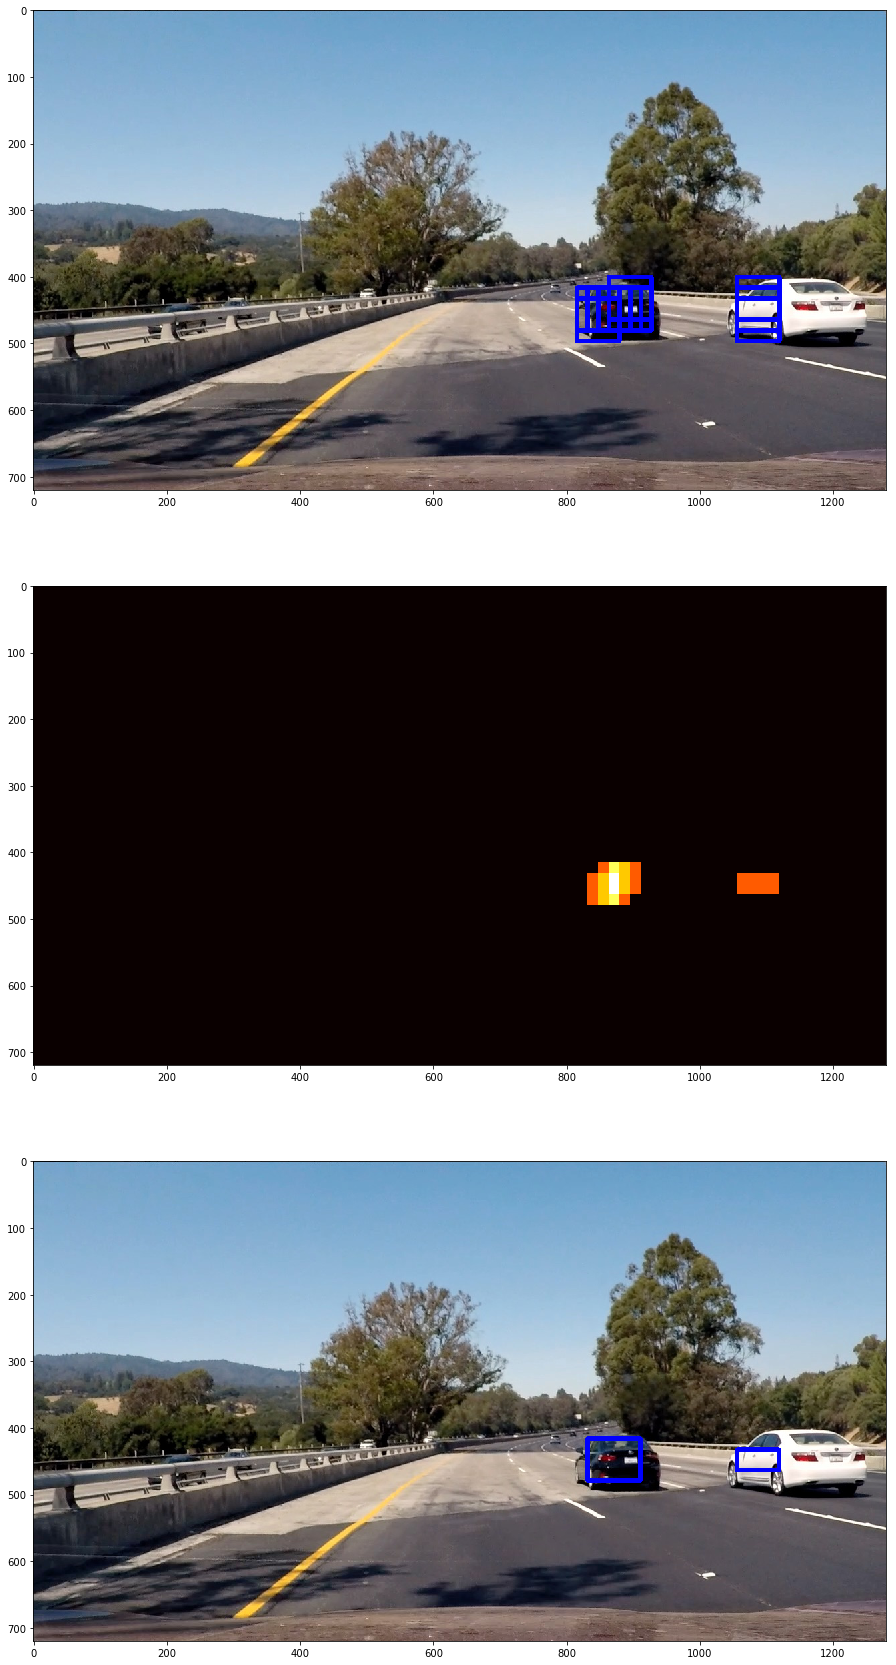

In [53]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
#                     xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
# 
#     
# def search_windows(img, windows, clf, scaler, color_space='RGB', 
#                     spatial_size=(32, 32), hist_bins=32, 
#                     hist_range=(0, 256), orient=9, 
#                     pix_per_cell=8, cell_per_block=2, 
#                     hog_channel=0, spatial_feat=True, 
#                     hist_feat=True, hog_feat=True):
#     
#     
# def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
#     

test_img = ".//test_images//test4.jpg"
test_img = cv2.imread(test_img)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

copy = np.copy(test_img)
windows = slide_window(test_img, y_start_stop = [400, 680], xy_window=(64, 64), xy_overlap = (0.75, 0.75))
#windows += slide_window(test_img ,y_start_stop = [400, 550], xy_window=(96, 96), xy_overlap = (0.75, 0.75))



good_windows = search_windows(test_img, windows, clf = svc, scaler = X_scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    hist_range=(0, 256), orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)

heatmap = np.zeros((test_img.shape[0], test_img.shape[1]), np.uint8)
threshold=2
heatmap = add_heat(heatmap, good_windows)
#heatmap of the image
heatmap = apply_threshold(heatmap, threshold=threshold)
#test_img = draw_boxes(test_img, windows2, color=(0,255,0), thick = 6)
test_img = draw_boxes(test_img, good_windows, color=(0,0,255), thick = 6)


labels = label(heatmap)
    
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(copy, labels)


plt.figure(2, figsize=(80, 30))
plt.subplot(311)
plt.imshow(test_img)
plt.subplot(312)
plt.imshow(heatmap, cmap='hot')
plt.subplot(313)
plt.imshow(draw_img)
plt.savefig(".//readme_images//heatmap.jpg", bbox_inches='tight')

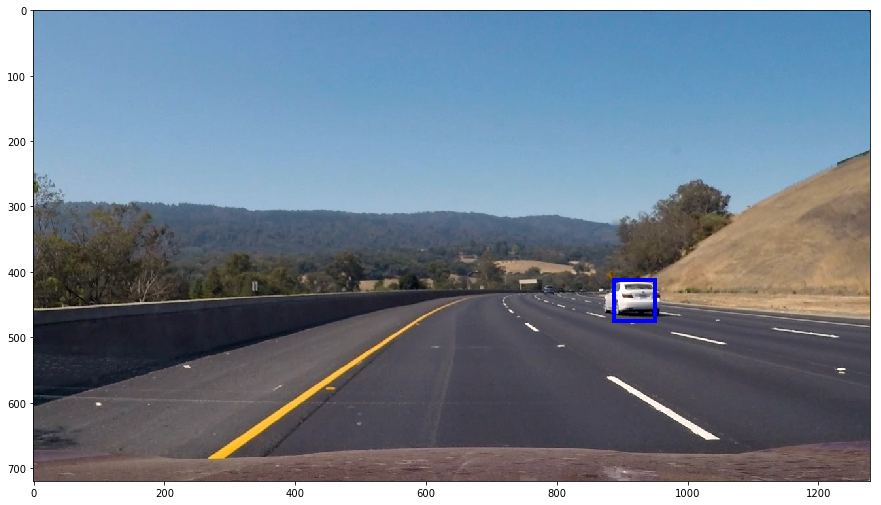

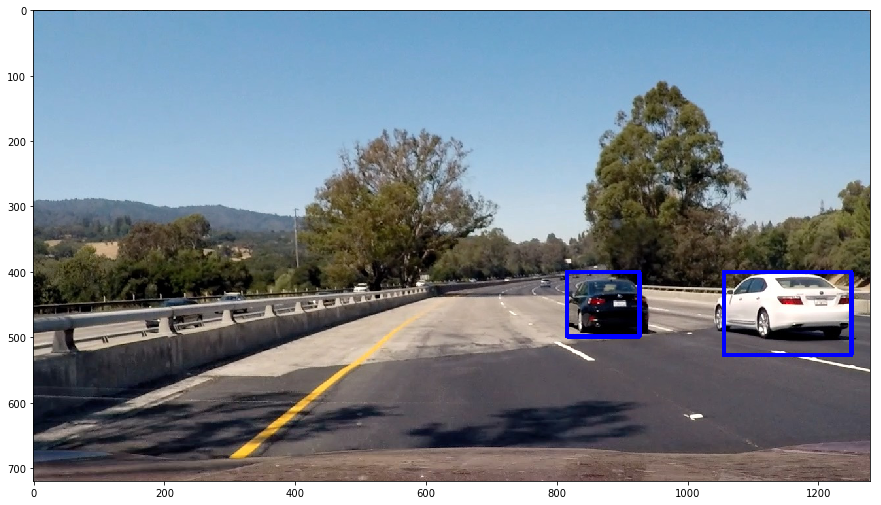

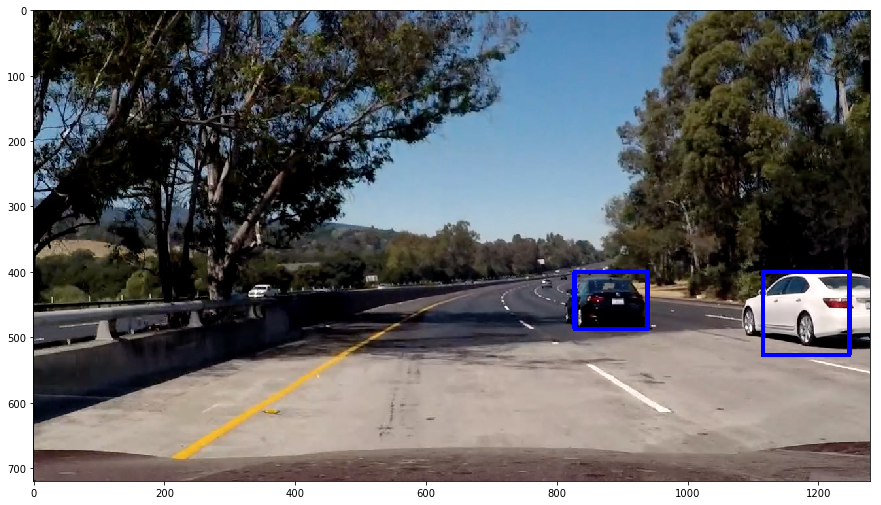

In [43]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

from collections import deque
#pipeline to test output on single images
def pipeline(img):
    
    heatmap = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    
    windows = slide_window(img, y_start_stop = [400, 680], xy_window=(128, 128), xy_overlap = (0.85, 0.85))
    windows += slide_window(img, y_start_stop = [400, 530], xy_window=(64, 64), xy_overlap = (0.80, 0.80))



    good_windows = search_windows(img, windows, clf = svc, scaler = X_scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    hist_range=(0, 256), orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)

    threshold=2
    heatmap = add_heat(heatmap, good_windows)
    heatmap = apply_threshold(heatmap, threshold=threshold)
    labels = label(heatmap)
    #print(labels[1], 'cars found')
    
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    

    return draw_img



heatmaps = deque(maxlen=10)


#function to be used to get output on videos, it is similar to pipeline() but thiss function averages out previously found
#heatmaps
def process_video(image):
    cimg = np.copy(image)
    
    windows = slide_window(image, y_start_stop = [400, 680], xy_window=(128, 128), xy_overlap = (0.85, 0.85))
    windows += slide_window(image ,y_start_stop = [400, 530], xy_window=(64, 64), xy_overlap = (0.80, 0.80))
    
    good_windows = search_windows(image, windows, clf = svc, scaler = X_scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    hist_range=(0, 256), orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)

    

    #print("iterations: ",iteration)
    global heatmaps
    if len(good_windows) > 0:
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        heat = add_heat(heat, good_windows)
        heatmaps.append(heat)
        # take recent 10 heatmaps and average them
        if len(heatmaps) == 10:
            avg_heat = sum(heatmaps)/len(heatmaps)
            heat = avg_heat
        heat = apply_threshold(heat, 2)
        heatmap = np.clip(heat, 0, 255)
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(cimg, labels)
    else:
        draw_img = cimg
    return draw_img
    
    

for i in range(3,6):    
    
    test_img = ".//test_images//test{}.jpg".format(i)
    test_img = cv2.imread(test_img)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    final_img = pipeline(test_img)
    plt.figure(figsize=(15,15))
    plt.imshow(final_img)
    plt.imsave(".//readme_images//test{}.jpg".format(i), final_img)


In [18]:
video_output = 'result.mp4'
clip1 = VideoFileClip('.//project_video.mp4')
white_clip = clip1.fl_image(process_video)
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [2:34:03<00:07,  7.39s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

